Collaborators: Vineeth Vemuri, Jared Wallenfels, Richard Chen

**Which player performed the best per 90 minutes in the 18/19 Premier League Season?**

The goal of this tutorial is to create a data visualization of statistics in the English Premier League 18/19 season. The data will be used to create an algorithm producing a skill rating for every player. These ratings will be used to rank the best performing players. Given that every position has variable expectations, certain statistics will vary greatly depending on duties of that position. As a result there must be a standardization of attributes between positions to account for differences in positional responsibilities. This provides a better idea of player performance as a whole relative to others in the same position. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files


# link to data: https://footystats.org/download-stats-csv
csv_file = "epl18-19stats.csv"
table = pd.read_csv(csv_file)

table.head()

,full_name,age,birthday,birthday_GMT,league,season,position,Current Club,minutes_played_overall,minutes_played_home,minutes_played_away,nationality,appearances_overall,appearances_home,appearances_away,goals_overall,goals_home,goals_away,assists_overall,assists_home,assists_away,penalty_goals,penalty_misses,clean_sheets_overall,clean_sheets_home,clean_sheets_away,conceded_overall,conceded_home,conceded_away,yellow_cards_overall,red_cards_overall,goals_involved_per_90_overall,assists_per_90_overall,goals_per_90_overall,goals_per_90_home,goals_per_90_away,min_per_goal_overall,conceded_per_90_overall,min_per_conceded_overall,min_per_match,min_per_card_overall,min_per_assist_overall,cards_per_90_overall,rank_in_league_top_attackers,rank_in_league_top_midfielders,rank_in_league_top_defenders,rank_in_club_top_scorer
0,Aaron Cresswell,31,629683200,1989/12/15,Premier League,2018/2019,Defender,West Ham United,1589,888,701,England,20,11,9,0,0,0,1,1,0,0,0,3,2,1,22,12,10,1,0,0.06,0.06,0.00,0.00,0.00,0,1.25,72,79,1589,1589,0.06,290,191,80,20
1,Aaron Lennon,33,545529600,1987/04/16,Premier League,2018/2019,Midfielder,Burnley,1217,487,730,England,16,7,9,1,1,0,1,1,0,0,0,4,2,2,20,8,12,1,0,0.15,0.07,0.07,0.18,0.00,1217,1.48,61,76,1217,1217,0.07,196,187,-1,10
2,Aaron Mooy,30,653356800,1990/09/15,Premier League,2018/2019,Midfielder,Huddersfield Town,2327,1190,1137,Australia,29,15,14,3,1,2,1,0,1,1,0,4,3,1,46,20,26,4,0,0.15,0.04,0.12,0.08,0.16,776,1.78,51,80,582,2327,0.15,144,233,-1,3
3,Aaron Ramsey,30,662169600,1990/12/26,Premier League,2018/2019,Midfielder,Arsenal,1327,689,638,Wales,28,14,14,4,2,2,6,5,1,0,0,7,6,1,12,2,10,0,0,0.68,0.41,0.27,0.26,0.28,332,0.81,111,47,0,221,0.00,69,8,-1,5
4,Aaron Rowe,20,968284800,2000/09/07,Premier League,2018/2019,Forward,Huddersfield Town,69,14,55,England,2,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.00,0.00,0.00,0.00,0.00,0,1.30,69,35,0,0,0.00,-1,-1,-1,31


In order to consider players who have made a significant impact in the season, we chose to filter the data to contain players who have played
900 or greater minutes. This equates to 10 full Premier league matches. This will filter out players who have not played enough minutes to accumulate sufficient data. There needs to be a significant enough amount of data for players if they are to be ranked properly.

In [ ]:
# Clean up the table because some values are arbitrary such as the league, season, birthday as well as renaming birthday_GMT to birthday for simplicity
table['birthday'] = table['birthday_GMT']
del table['birthday_GMT']
del table['league']
del table['season']

#filters table to have players with 900 or more minutes played
table = table.query("minutes_played_overall >= 900")
table

,full_name,age,birthday,position,Current Club,minutes_played_overall,minutes_played_home,minutes_played_away,nationality,appearances_overall,appearances_home,appearances_away,goals_overall,goals_home,goals_away,assists_overall,assists_home,assists_away,penalty_goals,penalty_misses,clean_sheets_overall,clean_sheets_home,clean_sheets_away,conceded_overall,conceded_home,conceded_away,yellow_cards_overall,red_cards_overall,goals_involved_per_90_overall,assists_per_90_overall,goals_per_90_overall,goals_per_90_home,goals_per_90_away,min_per_goal_overall,conceded_per_90_overall,min_per_conceded_overall,min_per_match,min_per_card_overall,min_per_assist_overall,cards_per_90_overall,rank_in_league_top_attackers,rank_in_league_top_midfielders,rank_in_league_top_defenders,rank_in_club_top_scorer
0,Aaron Cresswell,31,1989/12/15,Defender,West Ham United,1589,888,701,England,20,11,9,0,0,0,1,1,0,0,0,3,2,1,22,12,10,1,0,0.06,0.06,0.00,0.00,0.00,0,1.25,72,79,1589,1589,0.06,290,191,80,20
1,Aaron Lennon,33,1987/04/16,Midfielder,Burnley,1217,487,730,England,16,7,9,1,1,0,1,1,0,0,0,4,2,2,20,8,12,1,0,0.15,0.07,0.07,0.18,0.00,1217,1.48,61,76,1217,1217,0.07,196,187,-1,10
2,Aaron Mooy,30,1990/09/15,Midfielder,Huddersfield Town,2327,1190,1137,Australia,29,15,14,3,1,2,1,0,1,1,0,4,3,1,46,20,26,4,0,0.15,0.04,0.12,0.08,0.16,776,1.78,51,80,582,2327,0.15,144,233,-1,3
3,Aaron Ramsey,30,1990/12/26,Midfielder,Arsenal,1327,689,638,Wales,28,14,14,4,2,2,6,5,1,0,0,7,6,1,12,2,10,0,0,0.68,0.41,0.27,0.26,0.28,332,0.81,111,47,0,221,0.00,69,8,-1,5
5,Aaron Wan-Bissaka,23,1997/11/26,Midfielder,Crystal Palace,3135,1605,1530,England,35,18,17,0,0,0,3,1,2,0,0,12,7,5,41,17,24,5,1,0.09,0.09,0.00,0.00,0.00,0,1.18,76,90,523,1045,0.17,312,160,-1,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,Xherdan Shaqiri,29,1991/10/10,Midfielder,Liverpool,1058,538,520,Switzerland,24,12,12,6,5,1,3,0,3,0,0,12,7,5,5,3,2,2,0,0.77,0.26,0.51,0.84,0.17,176,0.43,212,44,529,353,0.17,15,39,-1,4
564,Yann Valery,22,1999/02/22,Defender,Southampton,1715,1070,645,France,23,13,10,2,1,1,1,1,0,0,0,3,1,2,26,17,9,5,1,0.16,0.05,0.10,0.08,0.14,858,1.36,66,75,343,1715,0.26,162,214,95,7
567,Youri Tielemans,23,1997/05/07,Midfielder,Leicester City,1092,575,517,Belgium,13,7,6,3,2,1,4,2,2,0,0,3,3,0,13,5,8,2,0,0.58,0.33,0.25,0.31,0.17,364,1.07,84,84,546,273,0.16,80,13,-1,4
568,Yves Bissouma,24,1996/08/30,Midfielder,Brighton & Hove Albion,1769,747,1022,Mali,28,13,15,0,0,0,0,0,0,0,0,5,4,1,30,14,16,5,0,0.00,0.00,0.00,0.00,0.00,0,1.53,59,63,354,0,0.25,402,293,-1,17


Determining aspects that will be used in a ranking algorithm are crucial in producing accurate results. You need to be sure that there is a relationship between these attributes in order to determine if it is a reliable variable. The most obvious statistic to be analyzed is goals, as they have the largest impact on the game. Goals are typically the first statistic looked at to determine player performance. 

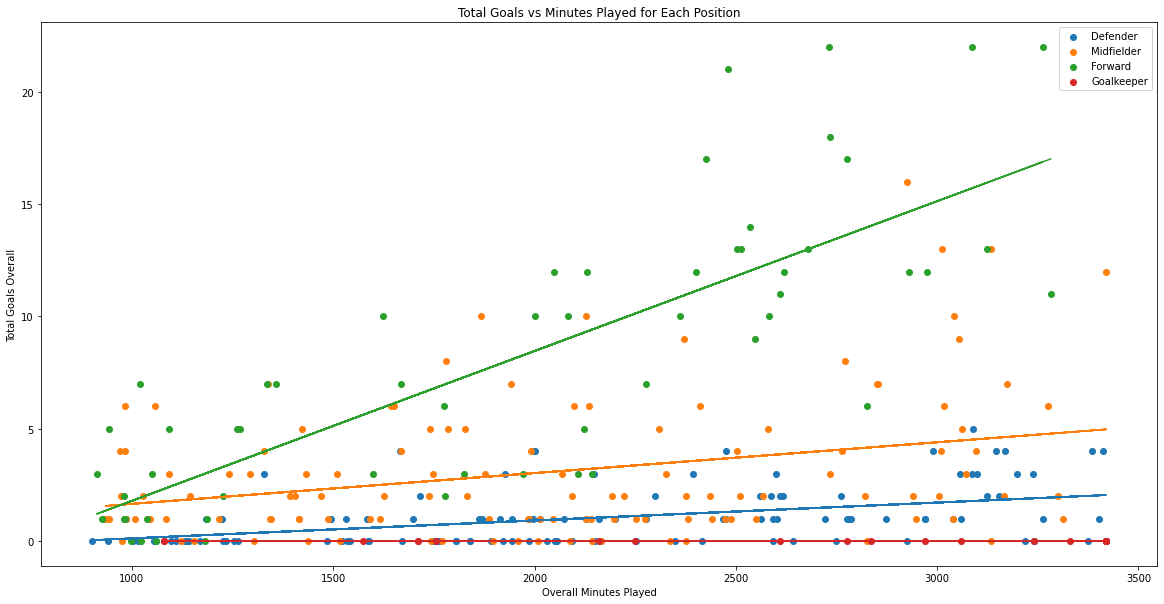

In [ ]:
# CODE TO REPRESENT GOALS VS MINUTES PLAYED

f = plt.figure(0)
f.set_figwidth(20)
f.set_figheight(10)

#labels plot
positions = table['position'].unique()
plt.xlabel("Overall Minutes Played")
plt.ylabel("Total Goals Overall")
plt.title("Total Goals vs Minutes Played for Each Position")

# plots overall goals by overall minutes for all players
# produces a scatter plot with regression lines for each position
for pos in positions:
  curr_pos = table.query("position == '{0}'".format(pos))
  mins = curr_pos['minutes_played_overall']
  goals = curr_pos['goals_overall']
  plt.scatter(mins, goals, label = pos)
  m, b = np.polyfit(curr_pos['minutes_played_overall'], 
                    curr_pos["goals_overall"], 1)
  plt.plot(curr_pos['minutes_played_overall'], 
           m*curr_pos['minutes_played_overall'] + b)

plt.legend()


This plot above represents total goals vs minutes played. We represented each position as a different color in order to differentiate peformances of each positions more specifically. The regression lines represent the expected goals as minutes played increases for each position based on data for that position. 

Based on the regression lines, we can see that goalkeepers have not scored goals. This data is Missing Not at Random, because goalkeepers are extremely unlikely to be involved with goal contributions. As a result, we expected the goalkeeper's goal amounts to be 0.  

We see that forwards are expected to score much more goals that midfielders, defenders, and goalkeepers based on regression lines. 

Scatter plots are good for showing general trends of data, violin plots provide density measures of data to show the distrubtion of data. Violin plots provide a better way of representing the goal distribution for each position. 

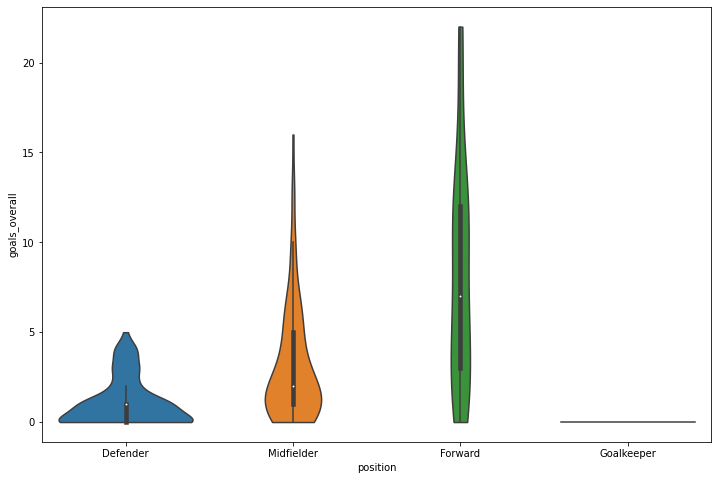

In [ ]:
import seaborn
# CODE TO REPRESENT STANDARD DEVIATION OF GOALS PER POSITION

plt.subplots(figsize = (12,8))

# creates the violin plot to represent goals by position
seaborn.violinplot(x= table["position"], y=table["goals_overall"], cut = 0)

Based on the violin plots, we can see the distribution of data changes per position. 
For defenders, the data produces a bottom heavy pyramid waning off at the top. There is much greater variance in goals scored for midfielders and forwards. Defenders scored in the range of 0 to 5 goals while midfielders and forwards scored up to the high teens/low twenties. This shows that there is a smaller goal gap in defenders when compared to the other positions.

For midfielders, the violin plot shows some centrality of data around the median, however there are outliers of midfielders who have scored much more than the average. This is likely because of the variety of roles that midfielders take on. Some midfielders may stay back and help the defenders, while others join the attack and contribute many goals. This factor accounts for the difference in weights conveyed on the violin plot.

For forwards, the distribution of data is much more spread out vertically, showing that the amount of goals scored by forwards varies greatly. The goals for forwards is likely a good indicator of skill since there is a consistent population of data appearing until 13 goals, dropping off after. Since very few players acheive such high goal tallies, this seems like a strong indication of determining talent for forwards. However, other data needs to be examined in order to compute skill rankings that are holistic of all statistics relating to players.

As you can see on the violin plot there is no data appearing for goalkeepers. This data is missing not at random because of the nature of the goalkeeping position. The duties of a goalkeeper are not to provide goals. While it is possible for goalkeeper to score, they are extremely rare and didn't occur in the 18/19 season. Goals can be used as a measurement for skill in other positions, however, they cannot be used for goalkeepers indicating a mismatch between ranking compatibility for goalkeepers and outfield players.

Standardizing data is a good way to compare data within a particular position. Its important to consider how a player performs against other players in their same position in order to see how players compare to one other.

In [ ]:
# CODE TO REPRESENT AVERAGE GOALS STANDARDIZATION
# NOTE: There are 90 minutes in a full length soccer game

# We chose to standardize by goals per 90 minutes, as it represents 
# more clearly how often a player scores which shows their efficiency of time 
# on the field. This is for players who have played 900 minutes or more.
avg_goals = table.groupby(['position'])['goals_per_90_overall'].mean()
std_goals = table.groupby(['position'])['goals_per_90_overall'].std()


table['std_goals_per_90'] = 0.0

for idx, row in table.iterrows():

  curr_goals = row['goals_per_90_overall']
  pos = row[3]
  avg_goal = avg_goals[pos]
  std_goal = std_goals[pos]

  # equation to standardize goals by position
  standardized_goals = (curr_goals - avg_goal)/std_goal
  table.at[idx, 'std_goals_per_90'] = standardized_goals

table

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


,full_name,age,birthday,position,Current Club,minutes_played_overall,minutes_played_home,minutes_played_away,nationality,appearances_overall,appearances_home,appearances_away,goals_overall,goals_home,goals_away,assists_overall,assists_home,assists_away,penalty_goals,penalty_misses,clean_sheets_overall,clean_sheets_home,clean_sheets_away,conceded_overall,conceded_home,conceded_away,yellow_cards_overall,red_cards_overall,goals_involved_per_90_overall,assists_per_90_overall,goals_per_90_overall,goals_per_90_home,goals_per_90_away,min_per_goal_overall,conceded_per_90_overall,min_per_conceded_overall,min_per_match,min_per_card_overall,min_per_assist_overall,cards_per_90_overall,rank_in_league_top_attackers,rank_in_league_top_midfielders,rank_in_league_top_defenders,rank_in_club_top_scorer,std_goals_per_90
0,Aaron Cresswell,31,1989/12/15,Defender,West Ham United,1589,888,701,England,20,11,9,0,0,0,1,1,0,0,0,3,2,1,22,12,10,1,0,0.06,0.06,0.00,0.00,0.00,0,1.25,72,79,1589,1589,0.06,290,191,80,20,-0.801818
1,Aaron Lennon,33,1987/04/16,Midfielder,Burnley,1217,487,730,England,16,7,9,1,1,0,1,1,0,0,0,4,2,2,20,8,12,1,0,0.15,0.07,0.07,0.18,0.00,1217,1.48,61,76,1217,1217,0.07,196,187,-1,10,-0.533692
2,Aaron Mooy,30,1990/09/15,Midfielder,Huddersfield Town,2327,1190,1137,Australia,29,15,14,3,1,2,1,0,1,1,0,4,3,1,46,20,26,4,0,0.15,0.04,0.12,0.08,0.16,776,1.78,51,80,582,2327,0.15,144,233,-1,3,-0.152922
3,Aaron Ramsey,30,1990/12/26,Midfielder,Arsenal,1327,689,638,Wales,28,14,14,4,2,2,6,5,1,0,0,7,6,1,12,2,10,0,0,0.68,0.41,0.27,0.26,0.28,332,0.81,111,47,0,221,0.00,69,8,-1,5,0.989387
5,Aaron Wan-Bissaka,23,1997/11/26,Midfielder,Crystal Palace,3135,1605,1530,England,35,18,17,0,0,0,3,1,2,0,0,12,7,5,41,17,24,5,1,0.09,0.09,0.00,0.00,0.00,0,1.18,76,90,523,1045,0.17,312,160,-1,22,-1.066770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,Xherdan Shaqiri,29,1991/10/10,Midfielder,Liverpool,1058,538,520,Switzerland,24,12,12,6,5,1,3,0,3,0,0,12,7,5,5,3,2,2,0,0.77,0.26,0.51,0.84,0.17,176,0.43,212,44,529,353,0.17,15,39,-1,4,2.817083
564,Yann Valery,22,1999/02/22,Defender,Southampton,1715,1070,645,France,23,13,10,2,1,1,1,1,0,0,0,3,1,2,26,17,9,5,1,0.16,0.05,0.10,0.08,0.14,858,1.36,66,75,343,1715,0.26,162,214,95,7,1.198524
567,Youri Tielemans,23,1997/05/07,Midfielder,Leicester City,1092,575,517,Belgium,13,7,6,3,2,1,4,2,2,0,0,3,3,0,13,5,8,2,0,0.58,0.33,0.25,0.31,0.17,364,1.07,84,84,546,273,0.16,80,13,-1,4,0.837080
568,Yves Bissouma,24,1996/08/30,Midfielder,Brighton & Hove Albion,1769,747,1022,Mali,28,13,15,0,0,0,0,0,0,0,0,5,4,1,30,14,16,5,0,0.00,0.00,0.00,0.00,0.00,0,1.53,59,63,354,0,0.25,402,293,-1,17,-1.066770


The value determined by the standardized equation represents how players
perform for scoring goals in comparison to other players in their position. As a result, this value is more useful than raw goal data to represent a player's skill.

It is also important to consider assists when determining player performance to aid in comparison of players. They are a good indicator of skill as they directly result in goals. Assists should be standardized by position as well, similarly to goals.

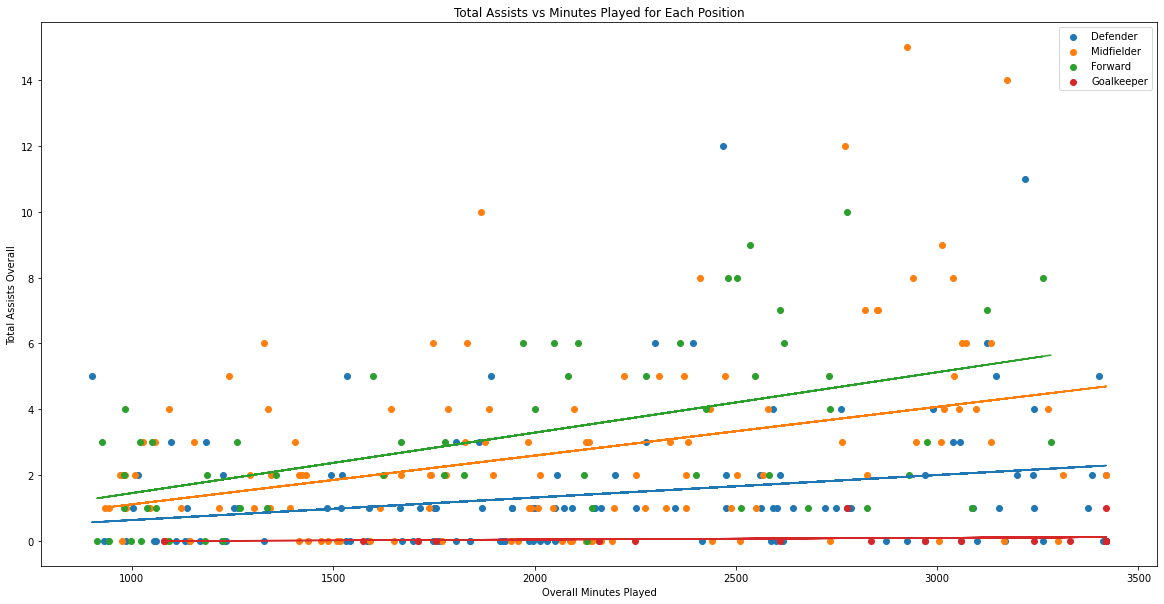

In [ ]:
# CODE TO REPRESENT ASSISTS VS MINUTES PLAYED

f = plt.figure(1)
f.set_figwidth(20)
f.set_figheight(10)
positions = table['position'].unique()


plt.xlabel("Overall Minutes Played")
plt.ylabel("Total Assists Overall")
plt.title("Total Assists vs Minutes Played for Each Position")

for pos in positions:
  
  #obtains minutes and assists from table
  curr_pos = table.query("position == '{0}'".format(pos))
  mins = curr_pos['minutes_played_overall']
  assists = curr_pos['assists_overall']
  #plots assists overall by minutes played for each player
  plt.scatter(mins, assists, label = pos)
  m, b = np.polyfit(curr_pos['minutes_played_overall'], curr_pos["assists_overall"], 1)
  plt.plot(curr_pos['minutes_played_overall'], m*curr_pos['minutes_played_overall'] + b)

plt.legend()

This plot above represents total assists vs minutes played for each player. We represented each position as a different color as well. The regression lines represent the expected assists for each position as minutes increase based on the data for that position.

Based on the regression line for goalkeepers, we can see that goalkeepers are not expected to assist. This data is Missing Not at Random, because goalkeepers are extremely unlikely to be involved with assists contributions. As a result, we expected the goalkeeper's goal amounts to be 0. However, we see that 2 goalkeepers had 1 assist each. This shows that goalkeepers can still contribute to goals, but it is typically expected that they have none. 

For the other positions, the regression lines show that forwards and midfielders are expected to have some similarity in assist output. Defenders not as much, and goalkeepers 0.  

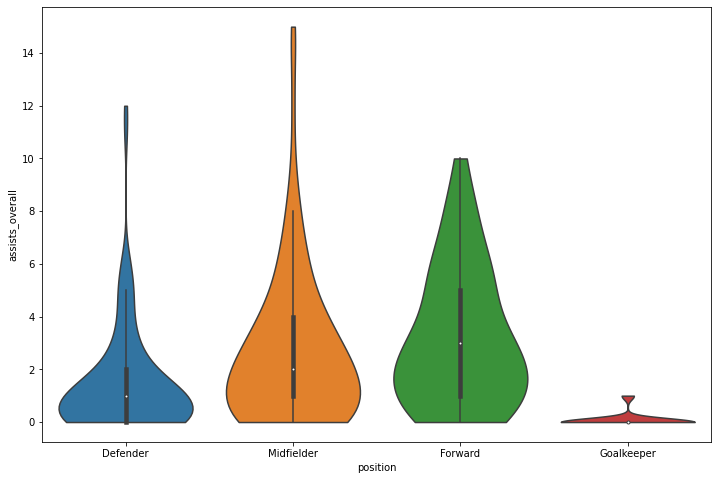

In [ ]:
# CODE TO REPRESENT STANDARD DEVIATION OF GOALS PER POSITION VIOLIN PLOT
plt.subplots(figsize = (12,8))
# creates the violin plot to represent goals by position
seaborn.violinplot(x=table["position"], y=table["assists_overall"], cut=0, scale='width')

This violin plot shows variability in terms of the distribution of assists, but not to the degree of the violin plot for goals by position. The violin plot for each position excluding the goalkeeper has a bottom heavy bulbous shape. This shows that assists are a good indicator of skill gap as most data is centralized around 0-5 assists with some outliers achieving high assists numbers. 

There are only 2 goalkeepers who have assisted in the 18/19 season (1 assist each), but it isn't an important statistic to their duties, simarily to goals. It shouldn't be a deciding factor of their skill. Much of the data is centralized around 0. 

Assists will be standardized by position for the same reasons above for standardizing goals. It makes comparisons easier. 

In [ ]:
# CODE TO REPRESENT AVERAGE ASSIST STANDARDIZATION


# We chose to standardize by assists per 90 minutes, as it represents 
# more clearly how often a player assists in a game, 
# which shows their efficiency of time on the field. 
# This is for players who have played 900 minutes or more.
avg_assists = table.groupby(['position'])['assists_per_90_overall'].mean()
std_assists = table.groupby(['position'])['assists_per_90_overall'].std()

table['std_assists_per_90'] = 0.0

for idx, row in table.iterrows():
  curr_assists = row[29]
  pos = row[3]
  avg_ast = avg_assists[pos]
  std_ast = std_assists[pos]
  
  #equation to standardize assists
  standardized_assists = (curr_assists - avg_ast)/std_ast

  table.at[idx, 'std_assists_per_90'] = standardized_assists

table

# The value determined by the standardized equation represents how players
# produce assists in comparison to other players in their position.

,full_name,age,birthday,position,Current Club,minutes_played_overall,minutes_played_home,minutes_played_away,nationality,appearances_overall,appearances_home,appearances_away,goals_overall,goals_home,goals_away,assists_overall,assists_home,assists_away,penalty_goals,penalty_misses,clean_sheets_overall,clean_sheets_home,clean_sheets_away,conceded_overall,conceded_home,conceded_away,yellow_cards_overall,red_cards_overall,goals_involved_per_90_overall,assists_per_90_overall,goals_per_90_overall,goals_per_90_home,goals_per_90_away,min_per_goal_overall,conceded_per_90_overall,min_per_conceded_overall,min_per_match,min_per_card_overall,min_per_assist_overall,cards_per_90_overall,rank_in_league_top_attackers,rank_in_league_top_midfielders,rank_in_league_top_defenders,rank_in_club_top_scorer,std_goals_per_90,std_assists_per_90
0,Aaron Cresswell,31,1989/12/15,Defender,West Ham United,1589,888,701,England,20,11,9,0,0,0,1,1,0,0,0,3,2,1,22,12,10,1,0,0.06,0.06,0.00,0.00,0.00,0,1.25,72,79,1589,1589,0.06,290,191,80,20,-0.801818,-0.006801
1,Aaron Lennon,33,1987/04/16,Midfielder,Burnley,1217,487,730,England,16,7,9,1,1,0,1,1,0,0,0,4,2,2,20,8,12,1,0,0.15,0.07,0.07,0.18,0.00,1217,1.48,61,76,1217,1217,0.07,196,187,-1,10,-0.533692,-0.434677
2,Aaron Mooy,30,1990/09/15,Midfielder,Huddersfield Town,2327,1190,1137,Australia,29,15,14,3,1,2,1,0,1,1,0,4,3,1,46,20,26,4,0,0.15,0.04,0.12,0.08,0.16,776,1.78,51,80,582,2327,0.15,144,233,-1,3,-0.152922,-0.711561
3,Aaron Ramsey,30,1990/12/26,Midfielder,Arsenal,1327,689,638,Wales,28,14,14,4,2,2,6,5,1,0,0,7,6,1,12,2,10,0,0,0.68,0.41,0.27,0.26,0.28,332,0.81,111,47,0,221,0.00,69,8,-1,5,0.989387,2.703335
5,Aaron Wan-Bissaka,23,1997/11/26,Midfielder,Crystal Palace,3135,1605,1530,England,35,18,17,0,0,0,3,1,2,0,0,12,7,5,41,17,24,5,1,0.09,0.09,0.00,0.00,0.00,0,1.18,76,90,523,1045,0.17,312,160,-1,22,-1.066770,-0.250088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,Xherdan Shaqiri,29,1991/10/10,Midfielder,Liverpool,1058,538,520,Switzerland,24,12,12,6,5,1,3,0,3,0,0,12,7,5,5,3,2,2,0,0.77,0.26,0.51,0.84,0.17,176,0.43,212,44,529,353,0.17,15,39,-1,4,2.817083,1.318918
564,Yann Valery,22,1999/02/22,Defender,Southampton,1715,1070,645,France,23,13,10,2,1,1,1,1,0,0,0,3,1,2,26,17,9,5,1,0.16,0.05,0.10,0.08,0.14,858,1.36,66,75,343,1715,0.26,162,214,95,7,1.198524,-0.122411
567,Youri Tielemans,23,1997/05/07,Midfielder,Leicester City,1092,575,517,Belgium,13,7,6,3,2,1,4,2,2,0,0,3,3,0,13,5,8,2,0,0.58,0.33,0.25,0.31,0.17,364,1.07,84,84,546,273,0.16,80,13,-1,4,0.837080,1.964979
568,Yves Bissouma,24,1996/08/30,Midfielder,Brighton & Hove Albion,1769,747,1022,Mali,28,13,15,0,0,0,0,0,0,0,0,5,4,1,30,14,16,5,0,0.00,0.00,0.00,0.00,0.00,0,1.53,59,63,354,0,0.25,402,293,-1,17,-1.066770,-1.080739


Now that goals and assists have been standardized by position, they can be analyzed to get an idea of a player's general attacking output compared to others in the same position. 

                          full_name    position
3                      Aaron Ramsey  Midfielder
45                 Andrew Robertson    Defender
80                   Benjamin Mendy    Defender
93                  Callum Paterson    Defender
115               Christian Eriksen  Midfielder
168                     Eden Hazard  Midfielder
169                         Ederson  Goalkeeper
183                    Fabian Schär    Defender
222                 Hector Bellerin    Defender
259         Javier Manquillo Gaitán    Defender
265                 Jeffrey Schlupp    Defender
283                     Jonas Lössl  Goalkeeper
334               Laurent Koscielny    Defender
343                      Leroy Sané  Midfielder
352  Lucas Rodrigues Moura da Silva  Midfielder
354                  Luciano Vietto     Forward
466                    Riyad Mahrez  Midfielder
476                    Ross Barkley  Midfielder
479              Ruben Loftus-Cheek  Midfielder
483                     Ryan Fraser  Mid

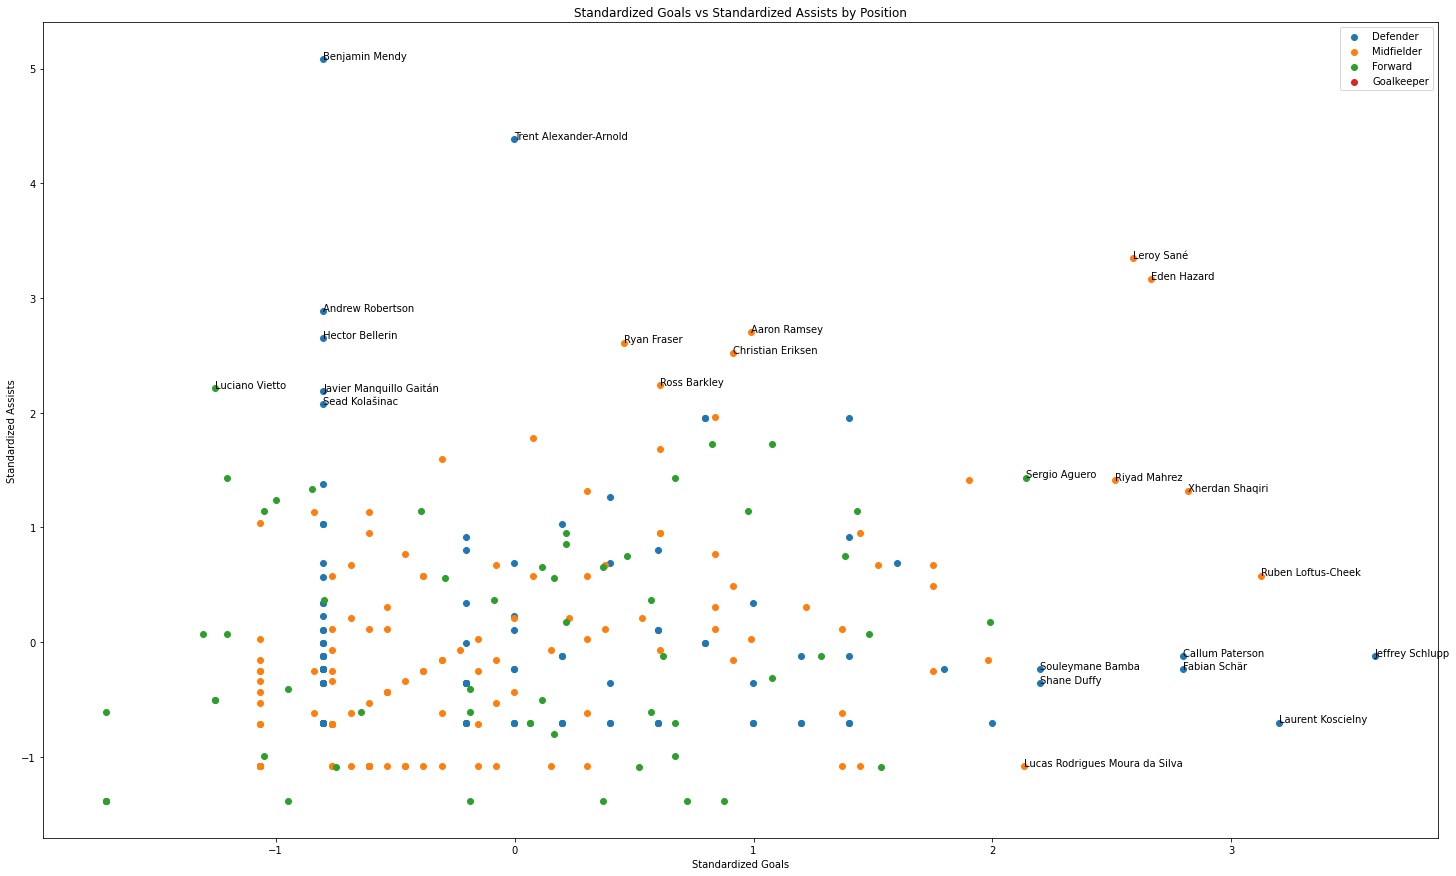

In [ ]:
# CODE TO REPRESENT STANDARDIZED GOALS VS STANDARDIZED ASSISTS
f = plt.figure(2)
f.set_figwidth(25)
f.set_figheight(15) 

plt.xlabel("Standardized Goals")
plt.ylabel("Standardized Assists")
plt.title("Standardized Goals vs Standardized Assists by Position")

for pos in positions:
  curr_pos = table.query("position == '{0}'".format(pos))
  std_goals90 = curr_pos['std_goals_per_90']
  std_assists90 = curr_pos['std_assists_per_90']
  plt.scatter(std_goals90, std_assists90, label = pos)

# labels all players who had standarized scores of 2.0 or higher, which are
# represented as 'elite' players
elite = table.query("std_goals_per_90 > 2.0 or std_assists_per_90 > 2.0")

#labels players who are in elite category
for idx, row in elite.iterrows():
  std_goal = row['std_goals_per_90']
  std_ast = row['std_assists_per_90']
  plt.annotate(row['full_name'], (std_goal, std_ast))

plt.legend()
print(elite[['full_name', 'position']].head(20))

This scatter plot represents the standardized goals vs standardized assists for each player that has played 900 or more minutes. This plot gives us an indication of which specific players performed greatly in terms of scoring or assisting. To determine which players were "elite", we chose to label all points that had a standardized assist or goal value of 2.0 or higher. This value was selected because most data is distributed within that axis. This as a result highlights stand out attacking performances.  

The number of elite players by position is represented below in a bar graph because there seemed to be a larger number of elite defenders than expected and the data needs to be further analyzed. As a result the values are compared to determine whether more variables must be considered for the ranking algorithm. 

Text(0.5, 1.0, 'Total Elite Players for Each Position')

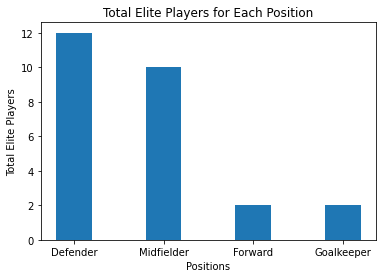

In [ ]:
# CODE TO PLOT THE COUNT OF TOTAL ELITE PLAYERS BY POSITION
f = plt.figure(3)
tot_elite = []
for pos in positions:
  curr_pos = elite.query("position == '{0}'".format(pos))
  tot_pos = curr_pos['full_name'].count()
  tot_elite.append(tot_pos)
  
plt.bar(positions, tot_elite, width = 0.4)
plt.xlabel("Positions")
plt.ylabel("Total Elite Players")
plt.title("Total Elite Players for Each Position")


119
124
57
24


Text(0.5, 1.0, 'Total Players for Each Position')

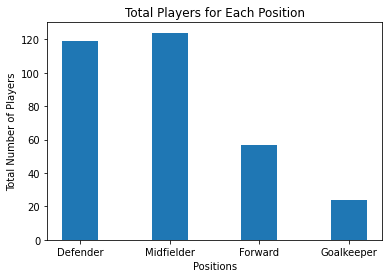

In [ ]:
# CODE TO PLOT THE COUNT OF TOTAL PLAYERS BY POSITION
f = plt.figure(3)
allplayers = []

for pos in positions:
  curr_pos = table.query("position == '{0}'".format(pos))
  tot_pos = curr_pos['full_name'].count()
  print(tot_pos)
  allplayers.append(tot_pos)


plt.bar(positions, allplayers, width = 0.4)
plt.xlabel("Positions")
plt.ylabel("Total Number of Players")
plt.title("Total Players for Each Position")

In [ ]:
# determines ratio of elite players by all players in a particular position
for i in range (len(positions)): 
  print((tot_elite[i] / allplayers[i]) * 100)

10.084033613445378
8.064516129032258
3.508771929824561
8.333333333333332


The first bar graph represents the number of players that were considered 'elite' for each position, and the second bar graph represents the total number of players in each position. After that, we obtained the ratio of elite players to total players in each position. It was determined that:

10.08% of defenders had an 'elite' season for assisting or scoring

8.06% of midfielders had an 'elite' season for assisting or scoring

3.51% of forwards had an 'elite' season for assisting or scoring

8.33% of goalkeepers had an 'elite' season for assisting or scoring

The percentage of 'elite' defenders and goalkeepers appears to be higher than expected, because we are only considering offensive output. Defenders and goalkeepers should mainly be scored on defensive contributions. So, we need to standardize the data over defensive contributions to filter out players who only had 'elite' offensive output instead of 'elite' total contribution to the game. The values are standardized over position, so any goal/assists for a defender or goalkeeper have more significance than a forward's goal/assist to their standardized value. Viewing the previous data, it is clear that goalkeepers must be ranked on a different algorithm to properly represent their own skill. As a result, the data should be split into goalkeepers and outfield players.

Three more variables are selected in order to get accurate predictions of the best performing players. These variables are the total goals conceded per 90, clean sheets overall, and minutes played overall. The first two give an indication of a team's defensive performance with a particular player in it, while the third provides an indication of a players fitness and longevity to be involved in games across the long season. These variables are standardized and included in the ranking algorithm.

In [ ]:
avg_conceded = table.groupby(['position'])['conceded_per_90_overall'].mean()
std_conceded = table.groupby(['position'])['conceded_per_90_overall'].std()

avg_clean_sheets = table.groupby(['position'])['clean_sheets_overall'].mean()
std_clean_sheets = table.groupby(['position'])['clean_sheets_overall'].std()

avg_mins_played = table.groupby(['position'])['minutes_played_overall'].mean()
std_mins_played = table.groupby(['position'])['minutes_played_overall'].std()


table['std_conceded_per_90'] = 0.0
table['std_clean_sheets'] = 0.0
table['std_minutes_played'] = 0.0

for idx, row in table.iterrows():

  curr_conceded = row['conceded_per_90_overall']
  curr_clean_sheets = row['clean_sheets_overall']
  curr_mins_played = row['minutes_played_overall']
  
  pos = row[3]

  avg_conced = avg_conceded[pos]
  std_conced = std_conceded[pos]

  avg_clean = avg_clean_sheets[pos]
  std_clean = std_clean_sheets[pos]

  avg_mins = avg_mins_played[pos]
  std_mins = std_mins_played[pos]

  # equation to determine standardized values
  standardized_conceded = (curr_conceded - avg_conced)/std_conced
  standardized_clean_sheets = (curr_clean_sheets - avg_clean)/std_clean
  standardized_mins_played = (curr_mins_played - avg_mins)/std_mins

  table.at[idx, 'std_conceded_per_90'] = standardized_conceded
  table.at[idx, 'std_clean_sheets'] = standardized_clean_sheets
  table.at[idx, 'std_minutes_played'] = standardized_mins_played

table

,full_name,age,birthday,position,Current Club,minutes_played_overall,minutes_played_home,minutes_played_away,nationality,appearances_overall,appearances_home,appearances_away,goals_overall,goals_home,goals_away,assists_overall,assists_home,assists_away,penalty_goals,penalty_misses,clean_sheets_overall,clean_sheets_home,clean_sheets_away,conceded_overall,conceded_home,conceded_away,yellow_cards_overall,red_cards_overall,goals_involved_per_90_overall,assists_per_90_overall,goals_per_90_overall,goals_per_90_home,goals_per_90_away,min_per_goal_overall,conceded_per_90_overall,min_per_conceded_overall,min_per_match,min_per_card_overall,min_per_assist_overall,cards_per_90_overall,rank_in_league_top_attackers,rank_in_league_top_midfielders,rank_in_league_top_defenders,rank_in_club_top_scorer,std_goals_per_90,std_assists_per_90,std_conceded_per_90,std_clean_sheets,std_minutes_played
0,Aaron Cresswell,31,1989/12/15,Defender,West Ham United,1589,888,701,England,20,11,9,0,0,0,1,1,0,0,0,3,2,1,22,12,10,1,0,0.06,0.06,0.00,0.00,0.00,0,1.25,72,79,1589,1589,0.06,290,191,80,20,-0.801818,-0.006801,-0.163220,-1.000958,-0.787425
1,Aaron Lennon,33,1987/04/16,Midfielder,Burnley,1217,487,730,England,16,7,9,1,1,0,1,1,0,0,0,4,2,2,20,8,12,1,0,0.15,0.07,0.07,0.18,0.00,1217,1.48,61,76,1217,1217,0.07,196,187,-1,10,-0.533692,-0.434677,0.561695,-0.960412,-1.195409
2,Aaron Mooy,30,1990/09/15,Midfielder,Huddersfield Town,2327,1190,1137,Australia,29,15,14,3,1,2,1,0,1,1,0,4,3,1,46,20,26,4,0,0.15,0.04,0.12,0.08,0.16,776,1.78,51,80,582,2327,0.15,144,233,-1,3,-0.152922,-0.711561,1.296659,-0.960412,0.386212
3,Aaron Ramsey,30,1990/12/26,Midfielder,Arsenal,1327,689,638,Wales,28,14,14,4,2,2,6,5,1,0,0,7,6,1,12,2,10,0,0,0.68,0.41,0.27,0.26,0.28,332,0.81,111,47,0,221,0.00,69,8,-1,5,0.989387,2.703335,-1.079726,-0.238648,-1.038671
5,Aaron Wan-Bissaka,23,1997/11/26,Midfielder,Crystal Palace,3135,1605,1530,England,35,18,17,0,0,0,3,1,2,0,0,12,7,5,41,17,24,5,1,0.09,0.09,0.00,0.00,0.00,0,1.18,76,90,523,1045,0.17,312,160,-1,22,-1.066770,-0.250088,-0.173270,0.964292,1.537519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,Xherdan Shaqiri,29,1991/10/10,Midfielder,Liverpool,1058,538,520,Switzerland,24,12,12,6,5,1,3,0,3,0,0,12,7,5,5,3,2,2,0,0.77,0.26,0.51,0.84,0.17,176,0.43,212,44,529,353,0.17,15,39,-1,4,2.817083,1.318918,-2.010681,0.964292,-1.421965
564,Yann Valery,22,1999/02/22,Defender,Southampton,1715,1070,645,France,23,13,10,2,1,1,1,1,0,0,0,3,1,2,26,17,9,5,1,0.16,0.05,0.10,0.08,0.14,858,1.36,66,75,343,1715,0.26,162,214,95,7,1.198524,-0.122411,0.094506,-1.000958,-0.612239
567,Youri Tielemans,23,1997/05/07,Midfielder,Leicester City,1092,575,517,Belgium,13,7,6,3,2,1,4,2,2,0,0,3,3,0,13,5,8,2,0,0.58,0.33,0.25,0.31,0.17,364,1.07,84,84,546,273,0.16,80,13,-1,4,0.837080,1.964979,-0.442757,-1.201000,-1.373519
568,Yves Bissouma,24,1996/08/30,Midfielder,Brighton & Hove Albion,1769,747,1022,Mali,28,13,15,0,0,0,0,0,0,0,0,5,4,1,30,14,16,5,0,0.00,0.00,0.00,0.00,0.00,0,1.53,59,63,354,0,0.25,402,293,-1,17,-1.066770,-1.080739,0.684189,-0.719824,-0.408873


The ranking algorithm uses standardized data from the goals, assists, and goals conceded per 90 minutes as well as a total number of clean sheets and minutes played. All of the values are considered positive besides goals conceded, which is factored in the algorthim by subtracting this from the overall rank. Having more goals conceded indicates a poor performance in that aspect. The other values are summed to bring the total rank value.  

In [ ]:
# This code returns the top ten performance ranks for each outfield position as well as 
# as the determined performance score. 
outfielders = table.query("position != 'Goalkeeper'")

outfielders['performance_score'] = 0.0

outfielders

for i, row in outfielders.iterrows():
  goals = row['std_goals_per_90']
  assists = row['std_assists_per_90']
  conceded = row['std_conceded_per_90']
  clean_sheets = row['std_clean_sheets']
  minutes = row['std_minutes_played']
  rank = goals + assists + clean_sheets + minutes - conceded
  outfielders.at[i, 'performance_score'] = rank

outfielders = outfielders.sort_values(by='performance_score', ascending=False)
outfielders = outfielders.reset_index()
outfielders.index += 1
defender_rank = outfielders.query("position == 'Defender'")
defender_rank = defender_rank.reset_index()
defender_rank.index += 1
midfielder_rank = outfielders.query("position == 'Midfielder'")
midfielder_rank = midfielder_rank.reset_index()
midfielder_rank.index += 1
forward_rank = outfielders.query("position == 'Forward'")
forward_rank = forward_rank.reset_index()
forward_rank.index += 1

print("Defender Top 10:\n",defender_rank[['full_name','performance_score']].head(10), '\n')
print("Midfielder Top 10:\n",midfielder_rank[['full_name','performance_score']].head(10), '\n')
print("Forward Top 10:\n",forward_rank[['full_name','performance_score']].head(10), '\n')
print("Overall Outfielders Top 10:\n",outfielders[['full_name','performance_score']].head(10), '\n')


Defender Top 10:
                  full_name  performance_score
1         Andrew Robertson           8.947573
2   Trent Alexander-Arnold           8.906818
3          Virgil van Dijk           8.302600
4          Aymeric Laporte           6.914418
5              Lucas Digne           5.708048
6               David Luiz           5.309370
7        Cesar Azpilicueta           5.276199
8            Marcos Alonso           4.903398
9              Kyle Walker           4.795259
10            Matt Doherty           4.706111 

Midfielder Top 10:
               full_name  performance_score
1           Eden Hazard           9.247111
2            Leroy Sané           9.018137
3           David Silva           6.760040
4        Bernardo Silva           6.475591
5          Riyad Mahrez           5.701188
6       Xherdan Shaqiri           5.689009
7      Gylfi Sigurdsson           5.467523
8          James Milner           5.340672
9     Christian Eriksen           5.304642
10  Georginio Wijnaldum 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# This code returns the top ten performance ranks for goalkeepers as well as 
# as the determined performance score. 
goalies = table.query("position == 'Goalkeeper'")

goalies['performance_ranking'] = 0.0

for i, row in goalies.iterrows():
  conceded = row['std_conceded_per_90']
  clean_sheets = row['std_clean_sheets']
  minutes = row['std_minutes_played']
  rank = clean_sheets + minutes - conceded
  goalies.at[i, 'performance_ranking'] = rank

goalies = goalies.sort_values(by='performance_ranking', ascending=False)
goalies = goalies.reset_index()
goalies.index += 1
print("Goalkeeper Top 10:\n", goalies[['full_name','performance_ranking']].head(10), '\n')

Goalkeeper Top 10:
                         full_name  performance_ranking
1                  Alisson Becker             5.810932
2                         Ederson             5.284130
3               Kepa Arrizabalaga             2.518773
4                 Jordan Pickford             2.445499
5                     Hugo Lloris             2.219446
6                 Martin Dúbravka             1.831642
7               Kasper Schmeichel             1.714891
8   Rui Pedro dos Santos Patrício             1.107975
9                Łukasz Fabiański             0.720272
10                   David de Gea             0.485957 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### **CONCLUSION**

After sifting through the standardized data and creating our own algorithms for the ranking process, we were able to determine the top 10 players for each position and the top 10 overall players in the 18/19 premier league season. 

In soccer, singling out certain statistics often paints a picture that doesn’t represent the real image. When we looked at purely goals and assists for each player and standardized it by position, we saw some unexpected players that were considered in the ‘elite’ range. For example, Hector Bellerin is considered an ‘elite’ defender based on assists in our plot. 

However, we need to consider more statistics that represent more than just an attacking output. Therefore, we considered defensive statistics such as clean sheets (no goals conceded in a game), goals conceded per 90, and minutes played overall to get a better picture on player performance. Once this was accounted for in our ranking determination, we could see that Hector Bellerin, despite performing well in assists, lacked good defensive stats. As a result, he was not in the top 10 list for defenders. This also applies to other positions on the field as well, besides goalkeeper of course.

We determined that a separate ranking for goalkeepers based purely on the defensive statistics would be more suitable. They have very little impact on goals or assists, although 2 goalkeepers (Ederson and Lossl) had 1 assist each in the 18/19 season. It makes little sense to factor in a largely irrelevant statistic for that position.

Overall, our ranking for each position and overall players seem to be very accurate. As soccer fans ourselves who watched the 18/19 season, we felt that these rankings were accurate to our own knowledge of these players. Besides our own knowledge on the game, a well known soccer analyst page called “FourFourTwo” (https://www.fourfourtwo.com/features/best-players-premier-league-201819) released their top 50 players for the 18/19 season. Our top 10 rankings for all players matched 7/10 of their players in the top 10 of that list.